# Estimation of FRET efficiency for emission for known dyes

Based on Medintz & Hildebrandt, 2014, pages 23-31.

FRET efficiency, $E$, is
$$
E = \frac{R_0^6}{R_0^6 + r_{DA}^6}
$$
where
$r_{DA}$ is the distance between donor and acceptor
and 
$R_0$ is the Förster distance.
This is also expressed as
$$
E = \frac{k_T}{k_T + 1/\tau_D}
$$
where
$k_T$ is the rate of energy transfer
and $t_D$ is the lifetime of the donor excited state in the absence of acceptor.
The formula for $k_T$ is
$$
k_T = \frac{1}{\tau_D} \left( \frac{R_0^6}{r_{DA}^6} \right)
$$

The Förster distance $R_0^6$ is a key quantity to compute,
and is given as
$$
R_0^6 = \frac{9 (\ln 10) \kappa^2 \Phi_D J }{128\pi^5 n^4 N_A}
$$
where $\kappa^2$ is the orientation factor,
$\Phi_D$ is the quantum yield of the donor fluorescence in the absence of acceptor,
$J$ is the overlap integral,
$\pi = 3.14159...$,
$n$ is the index of refraction of the medium,
and $N_A$ is the Avogadro number $6.0221415 \times 10^{23}$ per mol.

The overlap integral $J$, is computed differently depending on whether the spectra are given in terms of wavelength, wave number, or frequency. For wavelength,
$$
J^\lambda = J = \int f_D(\lambda) \epsilon_A(\lambda) \lambda^4 \mathrm{d} \lambda
$$
where $f_D(\lambda)$ is the peak-normalized fluorescence spectrum of the donor,
$\epsilon_A(\lambda)$ is the molar extinction coefficient (a.k.a. molar absorptivity) of the acceptor (usually in units of $\mathrm{M}^{-1} \mathrm{cm}^{-1}$), and $\lambda$ is the wavelength (usually in nm).

The molar absorptivity $\epsilon_A(\lambda)$ can be computed from
$$
\epsilon_A(\lambda) = f_A(\lambda) \epsilon_0 \Phi_A
$$


The overlap can be computed via the sum

$$
J^\lambda = \frac{\sum_i f_D(\lambda_i) \epsilon_A(\lambda_i) \lambda_i^4}{\sum_j f_D(\lambda_j)}
$$

In [28]:
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
def FRET_efficiency(R_0, r_DA):
    # Need both in same units.
    R6_0 = R_0**6
    E = R6_0 / (R6_0 + r_DA**6)
    return E

def forster_distance(kappa2, Phi_D, J, n):
    N_A = 6.0221415e23 # Avogadro number, per mol
    numerator = 9*math.log(10)*kappa2*Phi_D*J
    denominator = 128*(math.pi**5)*(n**4)*N_A
    R_0 = (numerator/denominator)**(1./6.)
    return R_0

def forster_distance_OLI(kappa2, Phi_D, J, n):
    R6_0 = kappa2*Phi_D*J/(n**4)
    R_0 = 4.542*(R6_0)**(1./6.) # nm
    return R_0

kappa2 = 2./3. # orientation factor for dipole interaction
# "The orientation factor takes on a value of κ² = 2/3 for a dynamic and
# isotropic distribution of donor and acceptor orientations"
# "Varies between 0 and 4."

n = 1.33 # index of refraction
# "All refractive index values in the literature are in the 1.33 - 1.6 range.
# The values 1.34 and 1.6 are the ones used most frequently."

r_DA = 2e-9 # 2 nm
r_DA_nm = 2
# FRET happens in the near field, that is, roughly in the 1-10 nm range."

Phi_D = 0.9
# Quantum efficiency of donor.
# "varies between 0 and 1"

Phi_A = 0.9
# Quantum efficiency of acceptor.

molar_attenuation_coefficient = 45e3 #  M^-1 cm^-1

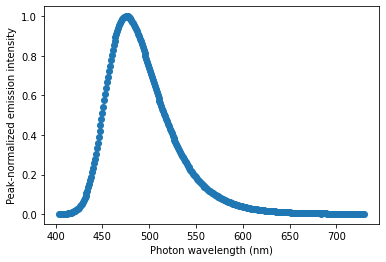

In [3]:
ATTO_390_emission_nm, ATTO_390_emission_intensity = np.loadtxt("ATTO_390_emission.csv", delimiter=",", unpack=True, skiprows=1)
plt.clf()
plt.scatter(ATTO_390_emission_nm, ATTO_390_emission_intensity)
plt.xlabel("Photon wavelength (nm)")
plt.ylabel("Peak-normalized emission intensity");

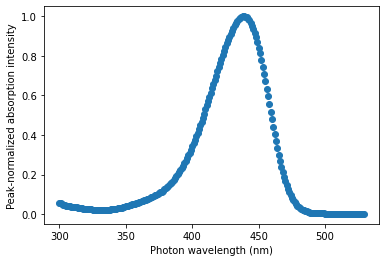

In [4]:
ATTO_425_absorption_nm, ATTO_425_absorption_intensity = np.loadtxt("ATTO_425_absorption.csv", delimiter=",", unpack=True, skiprows=1)
plt.clf()
plt.scatter(ATTO_425_absorption_nm, ATTO_425_absorption_intensity)
plt.xlabel("Photon wavelength (nm)")
plt.ylabel("Peak-normalized absorption intensity");

Now let's see what they look like overlaid.

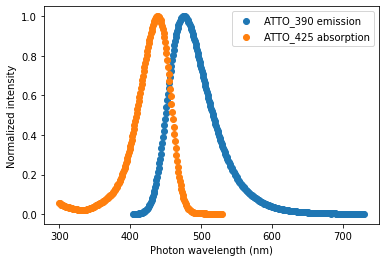

In [5]:
plt.clf()
plt.scatter(ATTO_390_emission_nm, ATTO_390_emission_intensity, label="ATTO_390 emission")
plt.scatter(ATTO_425_absorption_nm, ATTO_425_absorption_intensity, label="ATTO_425 absorption")
plt.xlabel("Photon wavelength (nm)")
plt.legend();
plt.ylabel("Normalized intensity");

In [6]:
def overlap_from_donor_OLI(
        donor_lambda,
        donor_fluorescence,
        acceptor_lambda,
        acceptor_extinction,
        molar_attenuation_coefficient):
    # In this method, we run over donor lambdas.
    assert len(donor_lambda) == len(donor_fluorescence)
    assert len(acceptor_lambda) == len(acceptor_extinction)
    # Peak-normalize donor fluorescence.
    donor_norm = donor_fluorescence/donor_fluorescence.max()
    # Peak-normalize acceptor.
    acceptor_norm = acceptor_extinction/acceptor_extinction.max()
    # Only go over the overlapping lambda range.
    lambda_min = max(donor_lambda.min(),acceptor_lambda.min())
    lambda_max = min(donor_lambda.max(),acceptor_lambda.max())
    wavelengths = []
    J_raw = []
    for i, wavelength_nm in enumerate(donor_lambda):
        if wavelength_nm < lambda_min:
            continue
        elif wavelength_nm > lambda_max:
            continue
        wavelengths.append(wavelength_nm)
        f_D = donor_norm[i]
        # Find index of closest corresponding wavelength in acceptor_lambda.
        # TODO: issue a warning if the acceptor data is too sparse.
        j = np.abs(acceptor_lambda - wavelength_nm).argmin()
        # eps_A has units of 1/(M cm)
        eps_A = acceptor_norm[j]*molar_attenuation_coefficient
        # OLI is 10^14 M^-1 cm^-1 nm^4
        J_val = 1e-14 * f_D * eps_A * (wavelength_nm**4)
        J_raw.append(J_val)
    lambda_J = np.array(wavelengths)
    J = np.array(J_raw) / donor_norm.sum()
    return lambda_J, J

In [7]:
lambda_J_donor, J_donor = overlap_from_donor_OLI(
    ATTO_390_emission_nm,
    ATTO_390_emission_intensity,
    ATTO_425_absorption_nm,
    ATTO_425_absorption_intensity,
    molar_attenuation_coefficient)

In [8]:
J_donor_sum = J_donor.sum()
print("J = {:.4g} * 10^14 M^-1 cm^-1 nm^4 (OLI)".format(J_donor_sum))

J = 3.388 * 10^14 M^-1 cm^-1 nm^4 (OLI)


In [9]:
R0_nm = forster_distance_OLI(kappa2, Phi_D, J_donor_sum, n = 1.33)
print("R0 = {:.4g} nm".format(R0_nm))
J_donor_sum_SI = J_donor_sum*1e-23
R0_m = forster_distance(kappa2, Phi_D, J_donor_sum_SI, n = 1.33)
print("R0 = {:.4g} m".format(R0_m))

R0 = 4.227 nm
R0 = 4.227e-09 m


In [10]:
R0_nm = forster_distance_OLI(kappa2, Phi_D, J_donor_sum, n = 1.6)
print("R0 = {:.4g} nm".format(R0_nm))
J_donor_sum_SI = J_donor_sum*1e-23
R0_m = forster_distance(kappa2, Phi_D, J_donor_sum_SI, n = 1.6)
print("R0 = {:.4g} m".format(R0_m))

R0 = 3.737 nm
R0 = 3.737e-09 m


This matches the FPBase FRET calculator:

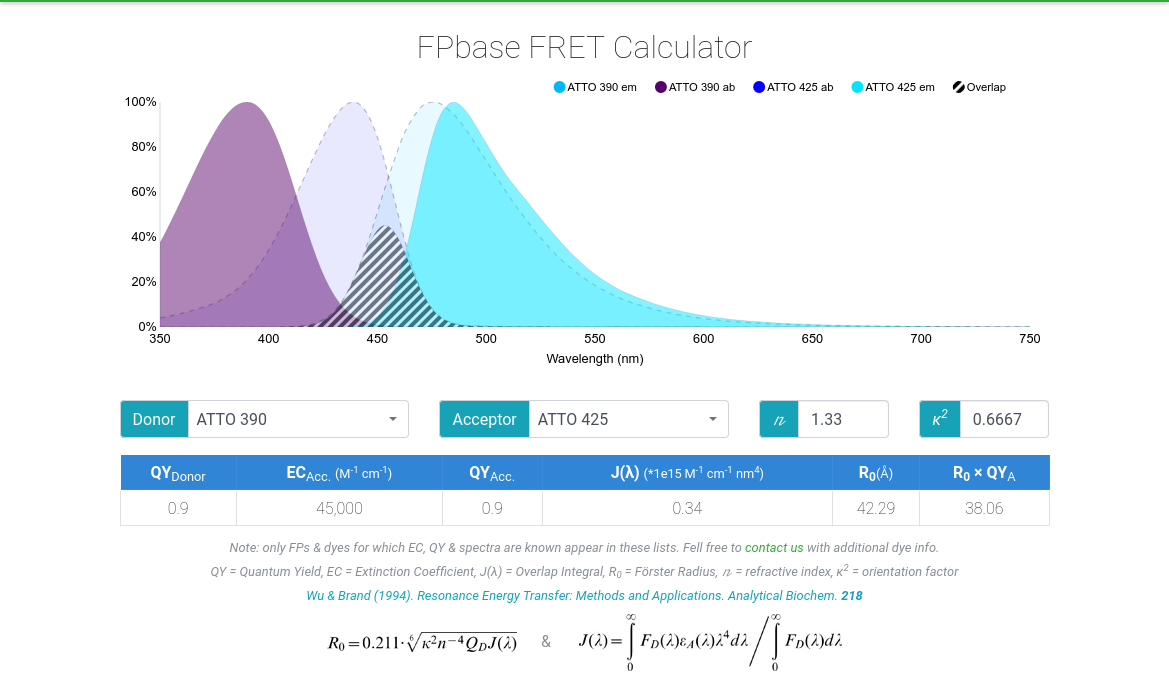

In [34]:
from IPython.display import Image
Image(filename="FPbase_FRET_Calculator.png")

In [11]:
E_total = FRET_efficiency(R0_nm, r_DA_nm)
print("E_total = {:.4g}".format(E_total))
E_total = FRET_efficiency(R0_m, r_DA)
print("E_total = {:.4g}".format(E_total))

E_total = 0.977
E_total = 0.9771


## End of main calculation.

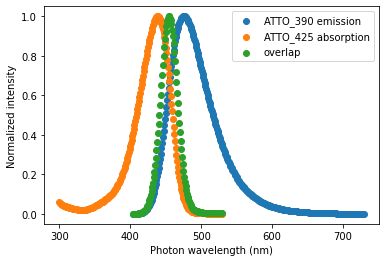

In [12]:
plt.clf()
plt.scatter(ATTO_390_emission_nm, ATTO_390_emission_intensity, label="ATTO_390 emission")
plt.scatter(ATTO_425_absorption_nm, ATTO_425_absorption_intensity, label="ATTO_425 absorption")
plt.scatter(lambda_J_donor, J_donor/J_donor.max(), label="overlap")
plt.xlabel("Photon wavelength (nm)")
plt.legend();
plt.ylabel("Normalized intensity");

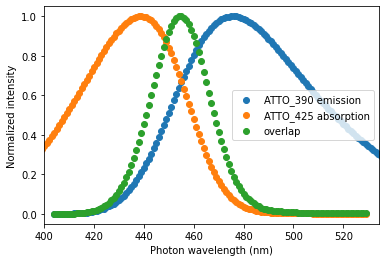

In [13]:
plt.clf()
plt.scatter(ATTO_390_emission_nm, ATTO_390_emission_intensity, label="ATTO_390 emission")
plt.scatter(ATTO_425_absorption_nm, ATTO_425_absorption_intensity, label="ATTO_425 absorption")
plt.scatter(lambda_J_donor, J_donor/J_donor.max(), label="overlap")
plt.xlabel("Photon wavelength (nm)")
plt.xlim([.99*lambda_J_donor.min(),1.01*lambda_J_donor.max()])
plt.legend();
plt.ylabel("Normalized intensity");

In [14]:
def overlap_from_acceptor_OLI(
        donor_lambda,
        donor_fluorescence,
        acceptor_lambda,
        acceptor_extinction,
        molar_attenuation_coefficient):
    # In this method, we run over acceptor lambdas.
    assert len(donor_lambda) == len(donor_fluorescence)
    assert len(acceptor_lambda) == len(acceptor_extinction)
    # Peak-normalize donor fluorescence.
    donor_norm = donor_fluorescence/donor_fluorescence.max()
    # Peak-normalize acceptor.
    acceptor_norm = acceptor_extinction/acceptor_extinction.max()
    # Only go over the overlapping lambda range.
    lambda_min = max(donor_lambda.min(),acceptor_lambda.min())
    lambda_max = min(donor_lambda.max(),acceptor_lambda.max())
    wavelengths = []
    J_raw = []
    for i, wavelength_nm in enumerate(acceptor_lambda):
        if wavelength_nm < lambda_min:
            continue
        elif wavelength_nm > lambda_max:
            continue
        wavelengths.append(wavelength_nm)
        # eps_A has units of 1/(M cm)
        eps_A = acceptor_norm[i]*molar_attenuation_coefficient
        # OLI is 10^14 M^-1 cm^-1 nm^4
        # Find index of closest corresponding wavelength in donor_lambda.
        # TODO: issue a warning if the acceptor data is too sparse.
        j = np.abs(donor_lambda - wavelength_nm).argmin()
        f_D = donor_norm[j]
        J_val = 1e-14 * f_D * eps_A * (wavelength_nm**4)
        J_raw.append(J_val)
    lambda_J = np.array(wavelengths)
    J = np.array(J_raw) / donor_norm.sum()
    return lambda_J, J

In [15]:
lambda_J_acceptor, J_acceptor = overlap_from_acceptor_OLI(ATTO_390_emission_nm, ATTO_390_emission_intensity, ATTO_425_absorption_nm, ATTO_425_absorption_intensity, molar_attenuation_coefficient)

In [16]:
J_acceptor_sum = J_acceptor.sum()
print(J_acceptor_sum)

3.3880501833255128


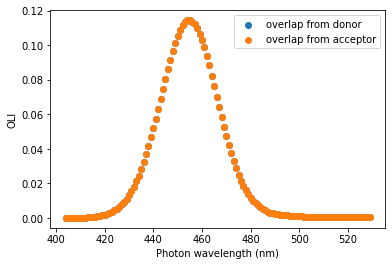

In [17]:
plt.clf()
plt.scatter(lambda_J_donor, J_donor, label="overlap from donor")
plt.scatter(lambda_J_acceptor, J_donor, label="overlap from acceptor")
plt.xlabel("Photon wavelength (nm)")
plt.legend();
plt.ylabel("OLI");

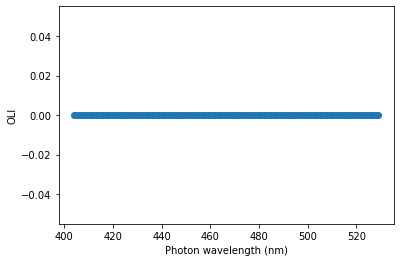

In [18]:
J_diff = J_donor - J_acceptor
plt.clf()
plt.scatter(lambda_J_acceptor, J_diff)
plt.xlabel("Photon wavelength (nm)")
plt.ylabel("OLI");

Instead of computing the overlap at each of the given lambda values, it is worth checking how much the overlap integral changes if the lambda range is chosen uniformly and the intensities are matched to the closest lambda values.

In [19]:
# Get a uniformly-spaced lambda range.
lambda_min = max(ATTO_390_emission_nm.min(),ATTO_425_absorption_nm.min())
lambda_max = min(ATTO_390_emission_nm.max(),ATTO_425_absorption_nm.max())
lambda_step = ATTO_390_emission_nm[1]-ATTO_390_emission_nm[0]
n_steps = int((lambda_max - lambda_min)/lambda_step)
lambda_range = np.linspace(lambda_min, lambda_max, n_steps)

def correspond(template, search_in):
    # Find the order of the closest corresponding values.
    order = []
    for val in template:
        order.append(np.abs(val - search_in).argmin())
    return order

ATTO_390_lambda_order = correspond(lambda_range, ATTO_390_emission_nm)
ATTO_390_intensity_new = ATTO_390_emission_intensity[ATTO_390_lambda_order]

ATTO_425_lambda_order = correspond(lambda_range, ATTO_425_absorption_nm)
ATTO_425_intensity_new = ATTO_425_absorption_intensity[ATTO_425_lambda_order]
ATTO_425_molar_absorption = molar_attenuation_coefficient*ATTO_425_intensity_new

def overlap_OLI(lambdas, donor_fluorescence, acceptor_extinction, molar_attenuation_coefficient):
    assert len(lambdas) == len(donor_fluorescence) == len(acceptor_extinction)
    # Peak-normalize donor fluorescence.
    f_D_norm = donor_fluorescence/donor_fluorescence.max()
    # Peak-normalize acceptor.
    eps_A_norm = acceptor_extinction/acceptor_extinction.max()
    eps_A_vals = eps_A_norm*molar_attenuation_coefficient
    J_raw = np.zeros(len(lambdas))
    for i, (wavelength_nm, f_D, eps_A) in enumerate(zip(lambdas, f_D_norm, eps_A_vals)):
        # eps_A has units of 1/(M cm)
        # OLI is 10^14 M^-1 cm^-1 nm^4
        J_raw[i] = 1e-14 * f_D * eps_A * (wavelength_nm**4)
    J = J_raw / f_D_norm.sum()
    return J

def overlap_SI_base(lambdas, donor_fluorescence, acceptor_extinction):
    assert len(lambdas) == len(donor_fluorescence) == len(acceptor_extinction)
    # Peak-normalize donor fluorescence.
    f_D_norm = donor_fluorescence/donor_fluorescence.max()
    J_raw = np.zeros(len(lambdas))
    for i, (wavelength_nm, f_D, eps_A) in enumerate(zip(lambdas, f_D_norm, acceptor_extinction)):
        wavelength_m = wavelength_nm*1e-9
        # eps_A has units of 1/(M cm) = 0.1 m^2/mol
        eps_A_m2 = 0.1*eps_A
        J_raw[i] = f_D*eps_A_m2 * (wavelength_m**4)
    # J_raw has units of m^6/mol
    J = J_raw / f_D_norm.sum()
    return J

def overlap_fpbase(lambdas, donor_fluorescence, acceptor_extinction):
    assert len(lambdas) == len(donor_fluorescence) == len(acceptor_extinction)
    # Peak-normalize donor fluorescence.
    f_D_norm = donor_fluorescence/donor_fluorescence.max()
    J_raw = np.zeros(len(lambdas))
    for i, (wavelength_nm, f_D, eps_A) in enumerate(zip(lambdas, f_D_norm, acceptor_extinction)):
        # TODO: why do they make this conversion?
        wavelength_cm = wavelength_nm*1e-7
        # eps_A has units of 1/(M cm)
        eps_A_m2 = eps_A
        J_raw[i] = f_D*eps_A_m2 * (wavelength_cm**4)
    # J_raw has units of cm^4 / M cm
    J = J_raw / f_D_norm.sum()
    return J

In [20]:
J_lambda_1 = overlap_SI_base(lambda_range, ATTO_390_intensity_new, ATTO_425_molar_absorption)
J_1 = J_lambda_1.sum()
print("J_1 = {:.4g} m^6/mol".format(J_1))
J_lambda_2 = overlap_fpbase(lambda_range, ATTO_390_intensity_new, ATTO_425_molar_absorption)
J_2 = J_lambda_2.sum()
print("J_2 = {:.4g} 1e15 M^-1 cm^-1 cm^4".format(J_2*1e15/100))
print("J_2 = {:.4g} cm^4 / (M cm)".format(J_2))
J_lambda_3 = overlap_OLI(lambda_range, ATTO_390_intensity_new, ATTO_425_molar_absorption, molar_attenuation_coefficient)
J_3 = J_lambda_3.sum()
print("J_3 = {:.4g} 10^14 M^-1 cm^-1 nm^4 (OLI)".format(J_3))

J_1 = 3.968e-23 m^6/mol
J_2 = 0.3968 1e15 M^-1 cm^-1 cm^4
J_2 = 3.968e-14 cm^4 / (M cm)
J_3 = 3.968 10^14 M^-1 cm^-1 nm^4 (OLI)


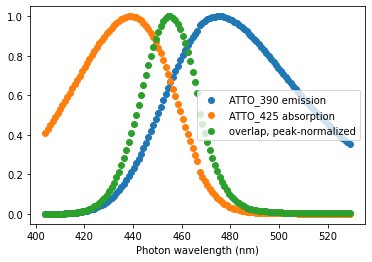

In [21]:
plt.clf()
plt.scatter(lambda_range, ATTO_390_intensity_new, label="ATTO_390 emission")
plt.scatter(lambda_range, ATTO_425_intensity_new, label="ATTO_425 absorption")
plt.scatter(lambda_range, J_lambda_1/J_lambda_1.max(), label="overlap, peak-normalized")
plt.legend()
plt.xlabel("Photon wavelength (nm)");

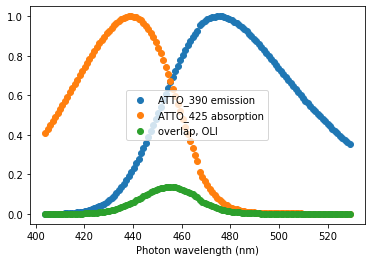

In [22]:
plt.clf()
plt.scatter(lambda_range, ATTO_390_intensity_new, label="ATTO_390 emission")
plt.scatter(lambda_range, ATTO_425_intensity_new, label="ATTO_425 absorption")
plt.scatter(lambda_range, J_lambda_3, label="overlap, OLI")
plt.legend()
plt.xlabel("Photon wavelength (nm)");

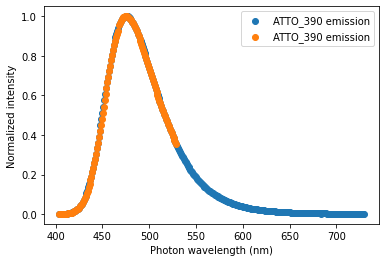

In [23]:
plt.clf()
plt.scatter(ATTO_390_emission_nm, ATTO_390_emission_intensity, label="ATTO_390 emission")
plt.scatter(lambda_range, ATTO_390_intensity_new, label="ATTO_390 emission")
plt.xlabel("Photon wavelength (nm)")
plt.legend();
plt.ylabel("Normalized intensity");

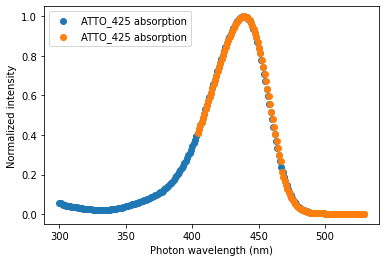

In [24]:
plt.clf()
plt.scatter(ATTO_425_absorption_nm, ATTO_425_absorption_intensity, label="ATTO_425 absorption")
plt.scatter(lambda_range, ATTO_425_intensity_new, label="ATTO_425 absorption")
plt.xlabel("Photon wavelength (nm)")
plt.legend();
plt.ylabel("Normalized intensity");

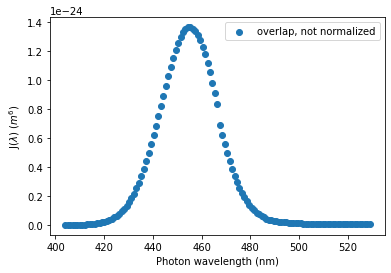

In [25]:
plt.clf()
plt.scatter(lambda_range, J_lambda_1, label="overlap, not normalized")
plt.legend()
plt.xlabel("Photon wavelength (nm)");
plt.ylabel("$\mathrm{J}(\lambda)$ ($m^6$)");

In [26]:
J_sum_1 = J_lambda_1.sum()
print(J_sum_1)
J_OLI = J_sum_1*1e23
print("{:.3f}×10¹⁵ M⁻¹ cm⁻¹ nm⁴".format(round(J_OLI,3)))

3.9677995336584235e-23
3.968×10¹⁵ M⁻¹ cm⁻¹ nm⁴


In [27]:
R0_m = forster_distance(kappa2, Phi_D, J_sum_1, n = 1.33)
R0_nm = R0_m*1e9
print("{} nm".format(R0_nm))

4.340173120577058 nm
